In [1]:
import sys  
sys.path.insert(0, './machine_learning_models')

from logistic_regression import logistic_regression
from stochastic_gradient_descent import stochastic_gradient_descent
from knn import knn
from kernel_svm import kernel_svm
from naive_bayes import naive_bayes
from random_forest import random_forest
from voting_classifier import voting_classifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output

In [2]:
league_id = 71 # Choose the league id
min_threshold = 1.75
max_threshold = 10

# default_stake = 50
bankroll = 2000
stake = 0.025

In [3]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    try:
        data_converted = np.unique(data, return_counts=True)[1]
        plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
        plt.title(title)
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show() 
    except Exception as e:
        print(f'Error when trying to plot the pie chart: {e}')
    
def get_season_year(season_id):
    if len(str(season_id)) == 4:
        return int(season_id)
    return int(str(season_id)[1:])

def check_bet_worth(prediction, odds_home, odds_away, odds_draw, pred_odds_home, pred_odds_away, pred_odds_draw):
    return ((prediction == 'H' and (pred_odds_home < odds_home) and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (pred_odds_away < odds_away) and (odds_away > min_threshold and odds_away < max_threshold)) or
            (prediction == 'D' and (pred_odds_draw < odds_draw) and (odds_draw > min_threshold and odds_draw < max_threshold)))

def check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw):
    game_money = 0
    
    if check_bet_worth(prediction, game['HOME_ODDS'], game['AWAY_ODDS'], game['DRAW_ODDS'], pred_odds_home, pred_odds_away, pred_odds_draw):
        if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
            game_money = (bet_value*game['HOME_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
            game_money = (bet_value*game['AWAY_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
            game_money = (bet_value*game['DRAW_ODDS'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

def check_game_with_odds(game, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw):
    
    prediction = 'D'
    if game['HOME_ODDS'] > game['AWAY_ODDS']:
        prediction = 'H'
    elif game['AWAY_ODDS'] > game['HOME_ODDS']:
        prediction = 'A'
    
    return check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)

def get_bet_value(bankroll):
    bankroll_baseline = round(bankroll / 1000, 0) * 1000
    return stake * bankroll_baseline
#     return default_stake

def get_pred_odds(probs):
    return 1/probs[0], 1/probs[1], 1/probs[2] # Away, Draw, Home

In [85]:
print('\nGetting data for the model...')

season_file = '2014-2022'

first_season_train = 2014
season_test = 2015

season = "{}-{}".format(first_season_train, season_test)

default_path = f'./leagues/{league_id}'
whole_dataset = (pd.read_csv(f'{default_path}/data/{season_file}.csv')).dropna()
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date

dataset = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season_train) & (whole_dataset['SEASON'] <= season_test)].reset_index(drop=True)

results = []

X = dataset.iloc[:, 9:-1].values
y = dataset.iloc[:, -1].values


Getting data for the model...


In [86]:
dataset.head()

,Unnamed: 0,GAME_ID,GAME_DATE,SEASON,HOME_TEAM,AWAY_TEAM,HOME_ODDS,AWAY_ODDS,DRAW_ODDS,HOME_PTS_PCT,...,AWAY_AWAY_DRAW_PCT,AWAY_AWAY_LOSS_PCT,AWAY_SCORED_LAST_5,AWAY_CONCEDED_LAST_5,AWAY_AWAY_SCORED_LAST_5,AWAY_AWAY_CONCEDED_LAST_5,AWAY_WIN_PCT_5,AWAY_DRAW_PCT_5,AWAY_LOSS_PCT_5,OUTCOME
0,0,190557,2014-07-26,2014,Santos,Chapecoense-SC,1.58,6.12,3.65,51.515152,...,20.000000,60.000000,1.0,0.8,0.333333,1.000000,60.0,0.0,40.0,H
1,1,190558,2014-07-26,2014,Cruzeiro,Figueirense,1.19,14.33,6.32,75.757576,...,16.666667,50.000000,0.8,1.2,1.500000,0.500000,20.0,20.0,60.0,H
2,2,190559,2014-07-26,2014,Criciuma,Vitoria,2.00,3.76,3.33,42.424242,...,50.000000,33.333333,0.4,1.0,0.666667,1.333333,0.0,60.0,40.0,A
3,3,190560,2014-07-26,2014,Bahia,Internacional,3.43,2.15,3.23,27.272727,...,80.000000,20.000000,1.8,1.2,1.000000,1.500000,40.0,20.0,40.0,A
4,4,190562,2014-07-27,2014,Corinthians,Palmeiras,1.77,4.81,3.41,60.606061,...,16.666667,50.000000,0.2,1.6,0.000000,1.333333,0.0,20.0,80.0,H


In [87]:
def train_lr_model(dataset):
    logisticRegression = logistic_regression(dataset)
    return logisticRegression[2]

def train_sgd_model(dataset):
    sgd = stochastic_gradient_descent(dataset)
    return sgd[2]

def train_knn_model(dataset):
    knn_model = knn(dataset)
    return knn_model[2]

def train_svm_model(dataset):
    svm = kernel_svm(dataset)
    return svm[2]

def train_nb_model(dataset):
    nb = naive_bayes(dataset)
    return nb[2]

def train_rf_model(dataset):
    rf = random_forest(dataset)
    return rf[2]

def train_voting_model(dataset):
#     logisticRegression = train_lr_model(dataset)
    svm = train_svm_model(dataset)
    nb = train_nb_model(dataset)
#     sgd = train_sgd_model(dataset)
#     knn_model = train_knn_model(dataset)
#     rf = train_rf_model(dataset)

    estimators = [('svm', svm), ('nb', nb)]
    weights = [1,1]
    
    vc = voting_classifier(dataset, estimators, weights)
    return vc[2]
    
def get_models(dataset):
    lr_model = train_lr_model(dataset)
    sgd = train_sgd_model(dataset)
    knn_model = train_knn_model(dataset)
    svm = train_svm_model(dataset)
    nb = train_nb_model(dataset)
    rf = train_rf_model(dataset)
    vc = train_voting_model(dataset)
    
    return lr_model, sgd, knn_model, svm, nb, rf, vc



Getting the feature correlation matrix...


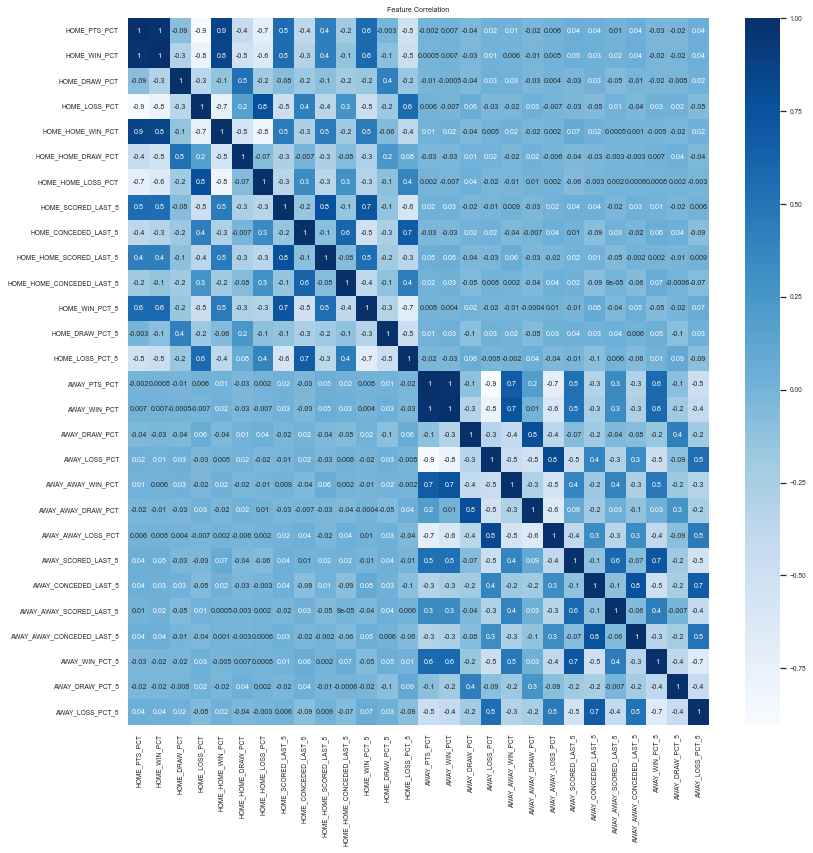

In [88]:
print('\nGetting the feature correlation matrix...')

import seaborn as sns

try:
    dependent_variables = dataset.iloc[:,9:]
    corrmat = dependent_variables.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(13,13))
    title = 'Feature Correlation'
    plt.title(title)
    #plot heat map
    sns.set(font_scale=0.6)
    g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()
except:
    print('No correlation matrix for the selected model.')

In [89]:
print("\nGetting data from the regular models for visualization...")
money_by_date = []
bets = []
money_by_team = dict()
# models = ['Logistic Regression', 'Stochastic Gradient Descent', 'KNN', 'Kernel SVM', 'Naive Bayes', 'Random Forest', 'Voting Classifier']
models = ['Testing']
total_invested = dict(zip([m for m in models], [0 for m in models]))
# parlay_model = dict(zip([x['model'] for x in results], [[0, True, []] for x in results]))
parlay_model = dict(zip([m for m in models], [[0, True, []] for m in models]))

# dataset_filtered = dataset.loc[dataset['GAME_DATE'] > dt.date(2022, 8, 25)]
dataset_itr = dataset.loc[dataset['SEASON'] == season_test].reset_index(drop=True)

# money_by_date.append([dataset_itr.iloc[0,2], dict(zip([x['model'] for x in results], [0 for x in results])),  dict(zip([x['model'] for x in results], [bankroll for x in results]))])
money_by_date.append([dataset_itr.iloc[0,2], dict(zip([m for m in models], [0 for m in models])),  dict(zip([m for m in models], [bankroll for m in models]))])

for index, game in dataset_itr.iterrows():
    clear_output(wait=True)
    
    print("{}/{}".format(index, len(dataset_itr.index)))
    
    # Next date
    if game['GAME_DATE'] != money_by_date[-1][0]:    
        # Tracking built parlay
        for model in money_by_date[-1][1]:
            if parlay_model[model][0] >= 1.5:
                bet_value = get_bet_value(money_by_date[-1][2][model])
                game_money_model = ((parlay_model[model][0] * bet_value) - bet_value) if parlay_model[model][1] else -bet_value
                total_invested[model] += bet_value
                money_by_date[-1][1][model] += game_money_model
                money_by_date[-1][2][model] += game_money_model
                if model == 'Voting Classifier' and parlay_model[model][0] > 0:
                    print('\nPARLAY LIST:')
                    print(f"ODDS: {parlay_model[model][0]} \nMATCHES: {parlay_model[model][2]}\n")
                    
#         parlay_model = dict(zip([x['model'] for x in results], [[0, True, []] for x in results]))
#         money_by_date.append([game['GAME_DATE'],  dict(zip([x['model'] for x in results], [0 for x in results])), dict(money_by_date[-1][2])])
        parlay_model = dict(zip([m for m in models], [[0, True, []] for m in models]))
        money_by_date.append([game['GAME_DATE'],  dict(zip([m for m in models], [0 for m in models])), dict(money_by_date[-1][2])])
    
    if game['HOME_TEAM'] not in money_by_team:
        money_by_team[game['HOME_TEAM']] = 0
    if game['AWAY_TEAM'] not in money_by_team:
        money_by_team[game['AWAY_TEAM']] = 0
    
#     print(f"\nGAME DATE: {game['GAME_DATE']}")
#     print(f"GAME OUTCOME: {game['OUTCOME']}")
#     print(f"PREDICTED OUTCOME: {y_pred[index]}")
#     print(f"GAME: {game['HOME_TEAM']} ({game['HOME_ODDS']}) x ({game['AWAY_ODDS']}) {game['AWAY_TEAM']}")
        
    dataset_train = dataset.loc[(dataset['GAME_DATE'] < game['GAME_DATE'])]
    X_train = dataset_train.iloc[:, 9:-1].values
    from sklearn.preprocessing import StandardScaler
    sc_train = StandardScaler()
    sc_train.fit(X_train)
    game_parameters = game.iloc[9:-1]
    X_transformed = sc_train.transform([game_parameters])
    
#     classifiers_list = get_models(dataset_train)
    classifiers_list = [train_voting_model(dataset_train)]
    classifiers = dict(zip([m for m in models], classifiers_list))

    for model in money_by_date[-1][1]:
        game_money_model = 0
        bet_value = get_bet_value(money_by_date[-1][2][model])

        classifier = classifiers[model]
        
        prediction = classifier.predict(X_transformed)[0]
        probs = classifier.predict_proba(X_transformed)[0]
        
        if probs[0] == 1 or probs[0] == 0:
            continue
            
        pred_odds_away, pred_odds_draw, pred_odds_home = get_pred_odds(probs)
        game_money_model = check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)
        
        if game_money_model != 0:
            if model == 'Voting Classifier': # Main Model
                if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
                    bets.append(['HOME', game['HOME_ODDS'], pred_odds_home, 1])
                    money_by_team[game['HOME_TEAM']] += game_money_model
                elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
                    bets.append(['AWAY', game['AWAY_ODDS'], pred_odds_away, 1])
                    money_by_team[game['AWAY_TEAM']] += game_money_model
                elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
                    bets.append(['DRAW', game['DRAW_ODDS'], pred_odds_draw, 1])
                else:
                    if prediction == 'H':
                        bets.append(['HOME', game['HOME_ODDS'], pred_odds_home, 0])
                        money_by_team[game['HOME_TEAM']] += game_money_model
                    elif prediction == 'A':
                        bets.append(['AWAY', game['AWAY_ODDS'], pred_odds_away, 0])
                        money_by_team[game['AWAY_TEAM']] += game_money_model
                    else:
                        bets.append(['DRAW', game['DRAW_ODDS'], pred_odds_draw, 0])
                        
            total_invested[model] += bet_value
            
        elif parlay_model[model][1] and prediction == game['OUTCOME']:
            odds = game['HOME_ODDS'] if prediction == 'H' else game['AWAY_ODDS'] if prediction == 'A' else game['DRAW_ODDS']
            parlay_model[model][0] = odds * parlay_model[model][0] if parlay_model[model][0] > 0 else odds # Parlay odds
            parlay_model[model][2].append(f"{game['HOME_TEAM']} ({game['HOME_ODDS']}) x ({game['AWAY_ODDS']}) {game['AWAY_TEAM']}") # Parlay match counter
        else:
            parlay_model[model][1] = False # Parlay failed
            
        money_by_date[-1][1][model] += game_money_model
        money_by_date[-1][2][model] += game_money_model



269/270


In [90]:
print(classifiers)

{'Testing': VotingClassifier(estimators=[('svm', SVC(probability=True, random_state=0)),
                             ('nb', GaussianNB())],
                 voting='soft', weights=[1, 1])}


In [91]:
print('\nProfit and margin by model...')
for model in money_by_date[-1][1]:
    if total_invested[model] > 0:
        won = money_by_date[-1][2][model] - bankroll
        print('Model: {} \t// Invested: {} \t// Won: {:.2f} \t// Margin: {:.2f}%'.format(model, total_invested[model], won, 100*won/total_invested[model]))


Profit and margin by model...
Model: Testing 	// Invested: 8625.0 	// Won: 90.48 	// Margin: 1.05%


In [92]:
print('\nPlotting charts...')

models_tracking =  [np.array([x[2][model] for x in money_by_date], dtype=np.float32) for model in money_by_date[-1][1]]

money_by_date = np.array(money_by_date, dtype=str)
correct_bets = list(filter(lambda x: x[3] == 1, bets))
missed_bets = list(filter(lambda x: x[3] == 0, bets))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(money_by_team.items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


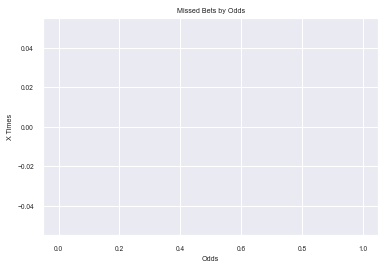

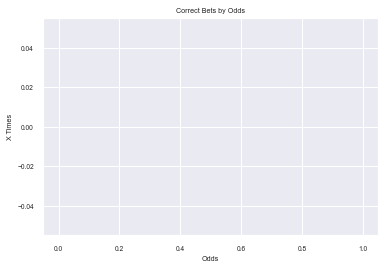

Error when trying to plot the pie chart: 'label' must be of length 'x'
Error when trying to plot the pie chart: 'label' must be of length 'x'


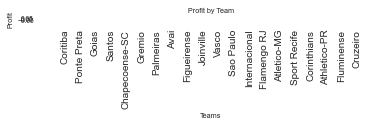

In [93]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away', 'Draw'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away', 'Draw'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

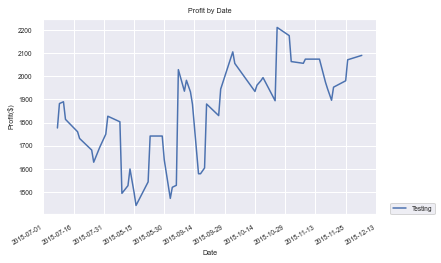

In [94]:
xpoints = money_by_date[:,0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)

title = "Profit by Date"
plt.legend([m for m in models], loc=(1.04,0))
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()